# Capstone Project 3: 
## Part II: Data Modeling, Predictions and Analysis of Results

In Part III of the project we will work with the data saved at the end of Part II.

The goal here is to create and optimize a classification model for achieving the best predictions possible based on the available data. For modeling and predictions we will use XGBClassifier which is arguably best suited for this problem.

In [1]:
# Import relevant libraries and packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style = 'whitegrid', font_scale = 1.8)

In [2]:
# Ignore warnings

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load saved data for modeling

data = pd.read_excel('data/jobs_ds_s1_s5_model.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Job Title           4846 non-null   object
 1   Industry            4846 non-null   object
 2   Job Function        4846 non-null   object
 3   Metro Area          4846 non-null   object
 4   Education-Bachelor  4846 non-null   int64 
 5   Education-Master    4846 non-null   int64 
 6   Education-Doctor    4846 non-null   int64 
 7   Seniority Level     4846 non-null   object
 8   Relevance Class     4846 non-null   int64 
 9   Position Demand     4846 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 378.7+ KB


In [4]:
data.head()

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance Class,Position Demand
0,Data Scientist,Staffing and Recruiting,Engineering,ATL,0,1,1,entry,3,3
1,Data Scientist,Staffing and Recruiting,Information Technology,ATL,1,1,0,entry,1,3
2,Data Scientist,Financial Services,Engineering,ATL,0,0,0,entry,2,3
3,Data Scientist,Financial Services,Engineering,ATL,0,1,0,entry,2,4
4,Data Scientist,Research,Analyst,ATL,0,0,0,entry,2,3


The data which will be used for modeling has 4846 data points. Our target is 'Position Demand' and the rest of the features are independent variables. Before proceeding with modeling we would like to deternine the Position Deamand values count, so that we can compare later with prediction results.

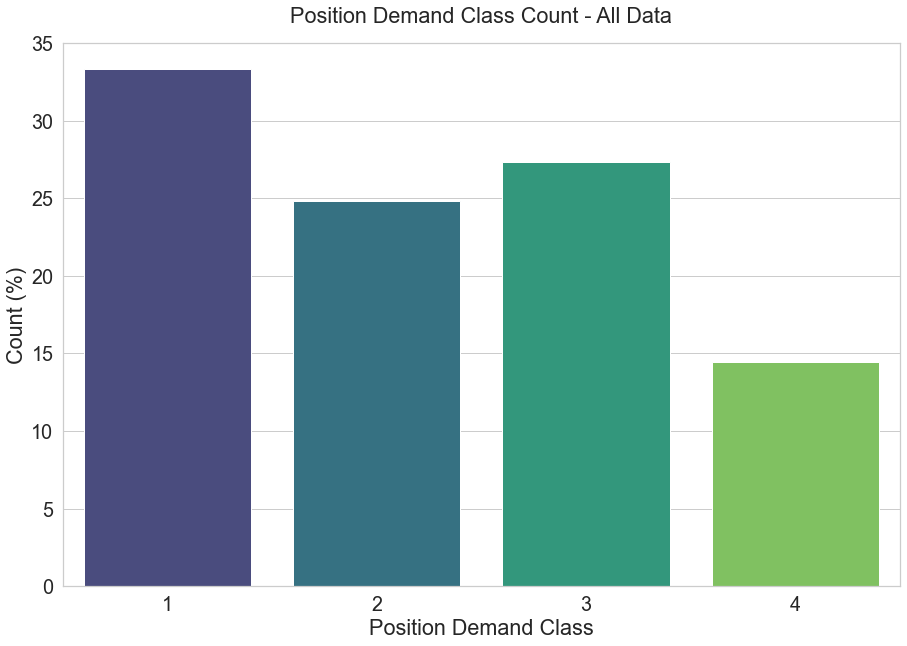

In [6]:
# get and plot the demand value count

count_demand = data['Position Demand'].value_counts(normalize = True) * 100

plt.figure(figsize = (15, 10))
sns.barplot(x = count_demand.index, y = count_demand.values, palette = 'viridis')
plt.xlabel('Position Demand Class')
plt.ylabel('Count (%)')
plt.title('Position Demand Class Count - All Data', pad = 20)
# plt.tick_params(axis = 'x', rotation = 90)
plt.show()

The plot shows relatively close participation of Classes 1, 2, and 3 in the data which will be used for modeling. If we focus only on postings in the Lowest demand category (Class 1 - less than six applicants per day), the plot indicates that if we pick in random from all positngs than we have a chance to pick correctly approximately one third of the time.

This is what we need to compare the results from our model predictions to.

### Replacing non-numerical with numerical categorical values

Before proceeding with modeling, we need to replace the current non-numerical categorical values with numerical categorical values in 'Job Title', 'Industry', 'Job Function', 'Metro Area', and 'Seniority Level'.

- **Job Title**

In [7]:
# get value count as percentages
count_title = data['Job Title'].value_counts(normalize = True) * 100
print(round(count_title, 2))

Data Scientist             54.56
Data Engineer              17.29
ML Engineer                10.05
Other                       6.05
Research Scientist          3.01
Manager                     2.33
Analyst                     1.67
Consultant                  1.13
Software Engineer           0.76
ML Specialist               0.74
Data Architect              0.72
Applied Scientist           0.54
Data Science Engineer       0.45
Scientist                   0.21
Quantitative Researcher     0.17
Director                    0.08
UX Researcher               0.08
Postdoctoral Researcher     0.06
Market Researcher           0.04
Researcher                  0.04
Name: Job Title, dtype: float64


In [8]:
print(count_title.index)

Index(['Data Scientist', 'Data Engineer', 'ML Engineer', 'Other',
       'Research Scientist', 'Manager', 'Analyst', 'Consultant',
       'Software Engineer', 'ML Specialist', 'Data Architect',
       'Applied Scientist', 'Data Science Engineer', 'Scientist',
       'Quantitative Researcher', 'Director', 'UX Researcher',
       'Postdoctoral Researcher', 'Market Researcher', 'Researcher'],
      dtype='object')


In [9]:
# create a dictionary to replace current non-numerical values
dict_title = {count_title.index[i]:(i+1) for i in range(len(count_title))}

print(dict_title)

{'Data Scientist': 1, 'Data Engineer': 2, 'ML Engineer': 3, 'Other': 4, 'Research Scientist': 5, 'Manager': 6, 'Analyst': 7, 'Consultant': 8, 'Software Engineer': 9, 'ML Specialist': 10, 'Data Architect': 11, 'Applied Scientist': 12, 'Data Science Engineer': 13, 'Scientist': 14, 'Quantitative Researcher': 15, 'Director': 16, 'UX Researcher': 17, 'Postdoctoral Researcher': 18, 'Market Researcher': 19, 'Researcher': 20}


In [10]:
# Replace the current categorical values with numerical categorical values
data['Job Title'].replace(dict_title, inplace=True)

# check
print(data['Job Title'].value_counts().index)

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20,
            19],
           dtype='int64')


We have replaced the non-numerical with numerical categorical values. We should keep in mind that 'Other' was replaced with 4, and the values 16 and below represent less than 0.1% of the data in case we would like to compare model results with and without these records.

- **Industry**

In [11]:
# get value count as percentages
count_industry = data['Industry'].value_counts(normalize = True) * 100
print(round(count_industry, 2))

Financial Services                     17.79
Internet                               15.41
Marketing and Advertising              11.58
Health Care                             7.08
Computer Software                       5.34
Defense                                 4.97
Management Consulting                   4.42
Staffing and Recruiting                 3.53
Biotechnology                           3.36
Insurance                               2.74
Information Technology and Services     2.62
Banking                                 2.54
Network Security                        1.75
Manufacturing                           1.63
Telecommunications                      1.47
Education                               1.34
Other                                   1.26
Research                                1.22
Automotive                              1.09
Retail                                  1.03
Construction                            0.83
Transportation                          0.74
Online Med

In [12]:
print(count_industry.index)

Index(['Financial Services', 'Internet', 'Marketing and Advertising',
       'Health Care', 'Computer Software', 'Defense', 'Management Consulting',
       'Staffing and Recruiting', 'Biotechnology', 'Insurance',
       'Information Technology and Services', 'Banking', 'Network Security',
       'Manufacturing', 'Telecommunications', 'Education', 'Other', 'Research',
       'Automotive', 'Retail', 'Construction', 'Transportation',
       'Online Media', 'Real Estate', 'Pharmaceutical', 'Wellness and Fitness',
       'Consumer Goods', 'Medical Devices', 'Food & Beverages',
       'Entertainment', 'Accounting', 'Environment', 'Computer Games',
       'Supply', 'Engineering', 'Consumer Electronics', 'Legal Services',
       'Nonprofit', 'Consumer Services', 'Energy', 'Apparel & Fashion',
       'Semiconductors', 'Investment'],
      dtype='object')


In [13]:
# create a dictionary to replace current non-numerical values
dict_industry = {count_industry.index[i]:(i+1) for i in range(len(count_industry))}

print(dict_industry)

{'Financial Services': 1, 'Internet': 2, 'Marketing and Advertising': 3, 'Health Care': 4, 'Computer Software': 5, 'Defense': 6, 'Management Consulting': 7, 'Staffing and Recruiting': 8, 'Biotechnology': 9, 'Insurance': 10, 'Information Technology and Services': 11, 'Banking': 12, 'Network Security': 13, 'Manufacturing': 14, 'Telecommunications': 15, 'Education': 16, 'Other': 17, 'Research': 18, 'Automotive': 19, 'Retail': 20, 'Construction': 21, 'Transportation': 22, 'Online Media': 23, 'Real Estate': 24, 'Pharmaceutical': 25, 'Wellness and Fitness': 26, 'Consumer Goods': 27, 'Medical Devices': 28, 'Food & Beverages': 29, 'Entertainment': 30, 'Accounting': 31, 'Environment': 32, 'Computer Games': 33, 'Supply': 34, 'Engineering': 35, 'Consumer Electronics': 36, 'Legal Services': 37, 'Nonprofit': 38, 'Consumer Services': 39, 'Energy': 40, 'Apparel & Fashion': 41, 'Semiconductors': 42, 'Investment': 43}


In [14]:
# Replace the current categorical values with numerical categorical values
data['Industry'].replace(dict_industry, inplace=True)

# check
print(data['Industry'].value_counts().index)

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 32, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43],
           dtype='int64')


We have replaced the non-numerical with numerical categorical values. Here, the category 'Other' represents only 1% of the data and all values except the last are above the 0.1% threshold. Therefore, we do not consider making predictions with and without these particular feature values.

- **Job Function**

In [15]:
# get value count as percentages
count_function = data['Job Function'].value_counts(normalize = True) * 100
print(round(count_function, 2))

Engineering               40.34
Information Technology    18.86
Other                     16.51
Analyst                    5.45
Research                   4.00
Consulting                 2.70
Sales                      2.17
Science                    1.59
Marketing                  1.53
General Business           1.28
Management                 1.09
Education                  0.87
Full-time                  0.85
Finance                    0.80
Business Development       0.31
Supply Chain               0.27
Advertising                0.23
Art                        0.21
Quality Assurance          0.17
Manufacturing              0.14
Human Resources            0.14
Accounting                 0.12
Health Care                0.12
Design                     0.10
Administrative             0.04
Legal                      0.04
Customer Service           0.02
Production                 0.02
Associate                  0.02
Name: Job Function, dtype: float64


In [16]:
print(count_function.index)

Index(['Engineering', 'Information Technology', 'Other', 'Analyst', 'Research',
       'Consulting', 'Sales', 'Science', 'Marketing', 'General Business',
       'Management', 'Education', 'Full-time', 'Finance',
       'Business Development', 'Supply Chain', 'Advertising', 'Art',
       'Quality Assurance', 'Manufacturing', 'Human Resources', 'Accounting',
       'Health Care', 'Design', 'Administrative', 'Legal', 'Customer Service',
       'Production', 'Associate'],
      dtype='object')


In [17]:
# create a dictionary to replace current non-numerical values
dict_function = {count_function.index[i]:(i+1) for i in range(len(count_function))}

print(dict_function)

{'Engineering': 1, 'Information Technology': 2, 'Other': 3, 'Analyst': 4, 'Research': 5, 'Consulting': 6, 'Sales': 7, 'Science': 8, 'Marketing': 9, 'General Business': 10, 'Management': 11, 'Education': 12, 'Full-time': 13, 'Finance': 14, 'Business Development': 15, 'Supply Chain': 16, 'Advertising': 17, 'Art': 18, 'Quality Assurance': 19, 'Manufacturing': 20, 'Human Resources': 21, 'Accounting': 22, 'Health Care': 23, 'Design': 24, 'Administrative': 25, 'Legal': 26, 'Customer Service': 27, 'Production': 28, 'Associate': 29}


In [18]:
# Replace the current categorical values with numerical categorical values
data['Job Function'].replace(dict_function, inplace=True)

# check
print(data['Job Function'].value_counts().index)

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 21, 20, 23, 22, 24, 26, 25, 27, 28, 29],
           dtype='int64')


We have replaced the non-numerical with numerical categorical values. We should keep in mind that values 25 and below represent less than 0.1% of data in case we would like to make predictions using different data subsets.

- **Metro Area**

In [19]:
# get value count as percentages
count_metro = data['Metro Area'].value_counts(normalize = True) * 100
print(round(count_metro, 2))

DC     15.13
NY     13.04
SF     12.94
BOS     9.78
SEA     7.90
CHI     7.20
LA      6.34
ATL     5.82
DAL     4.40
AUS     3.51
PHI     2.95
PHX     2.83
HOU     2.46
SD      2.31
POR     2.10
NC      1.30
Name: Metro Area, dtype: float64


In [20]:
print(count_metro.index)

Index(['DC', 'NY', 'SF', 'BOS', 'SEA', 'CHI', 'LA', 'ATL', 'DAL', 'AUS', 'PHI',
       'PHX', 'HOU', 'SD', 'POR', 'NC'],
      dtype='object')


In [21]:
# create a dictionary to replace current non-numerical values
dict_metro = {count_metro.index[i]:(i+1) for i in range(len(count_metro))}

print(dict_metro)

{'DC': 1, 'NY': 2, 'SF': 3, 'BOS': 4, 'SEA': 5, 'CHI': 6, 'LA': 7, 'ATL': 8, 'DAL': 9, 'AUS': 10, 'PHI': 11, 'PHX': 12, 'HOU': 13, 'SD': 14, 'POR': 15, 'NC': 16}


In [22]:
# Replace the current categorical values with numerical categorical values
data['Metro Area'].replace(dict_metro, inplace=True)

# check
print(data['Metro Area'].value_counts().index)

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], dtype='int64')


We have replaced the non-numerical with numerical categorical values.

- **Seniority Level**

In [23]:
# get value count as percentages
count_seniority = data['Seniority Level'].value_counts(normalize = True) * 100
print(round(count_seniority, 2))

senior       35.06
entry        32.69
associate    32.25
Name: Seniority Level, dtype: float64


In [24]:
print(count_seniority.index)

Index(['senior', 'entry', 'associate'], dtype='object')


In [25]:
# create a dictionary to replace current non-numerical values
dict_seniority = {'entry':1, 'associate':2, 'senior':3}

print(dict_seniority)

{'entry': 1, 'associate': 2, 'senior': 3}


In [26]:
# Replace the current categorical values with numerical categorical values
data['Seniority Level'].replace(dict_seniority, inplace=True)

# check
print(data['Seniority Level'].value_counts().index)

Int64Index([3, 1, 2], dtype='int64')


In [27]:
# final check of data
data.head(10)

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance Class,Position Demand
0,1,8,1,8,0,1,1,1,3,3
1,1,8,2,8,1,1,0,1,1,3
2,1,1,1,8,0,0,0,1,2,3
3,1,1,1,8,0,1,0,1,2,4
4,1,18,4,8,0,0,0,1,2,3
5,1,6,1,8,1,0,0,1,3,3
6,1,21,1,8,0,1,0,1,3,3
7,1,8,2,8,1,0,0,1,2,3
8,1,3,1,8,0,0,0,1,3,3
9,1,2,1,8,0,0,0,1,2,4


We have successfully replaced all non-numerical with numerical categorical values and are ready to proceed with data modeling.

### Data modeling using XGBClassifier

In our modeling, the focus is on achieving high Class 1 precision and relatively good recall. The reason to put the emphasis on precision is that we do not want to have records belonging to other classes, Class 3 and 4 in particular, to be mis-classified as Class 1. At the same time we want to have a relatively good recall, so that we do not want to categorize too many Class 1 records as belonging to another class, which will limit the final pool of postings from which we will be selecting postings matching our additional criteria.

In [28]:
# Create subsets of independent and dependent (target) variables

# independent variables
X = data.iloc[:, 0:9].values # includes all features, but target

# target
y = data.iloc[:, -1].values # target - 'Position Demand'

In [29]:
# Split into train and test subsets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

- **XGBClassifier without optimization**

In [30]:
# create XGBClassifier model
from xgboost import XGBClassifier
model_1 = XGBClassifier(objective = 'multi:softprob') # objective = 'multi:softprob' is used for multiclass classification

In [31]:
# train and predict
model_1 = model_1.fit(X_train, y_train)

y_pred_1 = model_1.predict(X_test)

In [32]:
# evaluate model performance
from sklearn.metrics import confusion_matrix, classification_report

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_1))
print('\n')
print('Classification Report:')
print(classification_report(y_test,  y_pred_1))

Confusion Matrix:
[[206  33  56  10]
 [132  53  56  16]
 [117  34  81  25]
 [ 54  15  50  32]]


Classification Report:
              precision    recall  f1-score   support

           1       0.40      0.68      0.51       305
           2       0.39      0.21      0.27       257
           3       0.33      0.32      0.32       257
           4       0.39      0.21      0.27       151

    accuracy                           0.38       970
   macro avg       0.38      0.35      0.34       970
weighted avg       0.38      0.38      0.36       970



The model without optimization has achived 40% Class 1 precision, which is not a significant improvement over a random choice. However it's recall of 68% is relatively good. 

Due to the low precision we will use Bayesian optimization to try to improve our results.

- **XGBClassifier with Bayesian optimization**

In [33]:
# import XGB optimization packages

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn import metrics

In [34]:
#  For the optimization split the original training set into new train/test sets

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size = 0.30, random_state = 42)

    - Optimization 1 - metrics.precision_score

In [35]:
# Optimization 1 - metrics.precision_score

# create hyperparameter space to search over
space = {'max_depth': hp.choice('max_depth', np.arange(3, 15, 1, dtype = int)),
        'n_estimators': hp.choice('n_estimators', np.arange(50, 300, 10, dtype = int)),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1.0, 0.1),
        'min_child_weight': hp.choice('min_child_weight', np.arange(0, 10, 1, dtype = int)),
        'subsample': hp.quniform('subsample', 0.5, 1.0, 0.1),
        'learning_rate': hp.quniform('learning_rate', 0.1, 0.3, 0.1),
         'gamma': hp.choice('gamma', np.arange(0, 20, 1.0, dtype = float)),
         'reg_alpha': hp.choice('reg_alpha', np.arange(0, 20, 1.0, dtype = float)),
         'reg_lambda': hp.choice('reg_lambda', np.arange(0, 20, 1.0, dtype = float)),
         
        'objective':'multi:softprob'} # multiclass - use 'objective':'multi:softprob', binary - use 'objective':'binary:logistic'

# define number for max_evals
n_evals = 500

def score_precision(params):
    model = XGBClassifier(**params, n_jobs=-1)
    
    model.fit(X_train1, y_train1, eval_set=[(X_train1, y_train1), (X_test1, y_test1)],
              verbose = False, early_stopping_rounds = 25) # 25 gives better results than 50 and 20!!!
    
    y_pred = model.predict(X_test1)

    # metrics.precision_score
    score = -metrics.precision_score(y_test1, y_pred, pos_label = 1, average = 'micro', 
                                     sample_weight = None, zero_division = 'warn') # keep average = 'micro'!!!
    print(score)
    return {'loss': score, 'status': STATUS_OK}    
    
def optimize_precision(trials, space):
    
    best = fmin(score_precision, space, algo = tpe.suggest, max_evals = n_evals)
    return best

In [36]:
# Run Opt. 1
n_evals = 500

trials = Trials()
best_params = optimize_precision(trials, space)

-0.3723129836629407                                                                                                    
-0.3860705073086844                                                                                                    
-0.3817712811693895                                                                                                    
-0.3619948409286328                                                                                                    
-0.3938091143594153                                                                                                    
-0.3895098882201204                                                                                                    
-0.355116079105761                                                                                                     
-0.36371453138435084                                                                                                   
-0.3886500429922614                     

-0.39122957867583835                                                                                                   
-0.37317282889079967                                                                                                   
-0.355116079105761                                                                                                     
-0.355116079105761                                                                                                     
-0.355116079105761                                                                                                     
-0.355116079105761                                                                                                     
-0.355116079105761                                                                                                     
-0.355116079105761                                                                                                     
-0.355116079105761                      

-0.4178847807394669                                                                                                    
-0.4178847807394669                                                                                                    
-0.4204643164230438                                                                                                    
-0.43594153052450557                                                                                                   
-0.43594153052450557                                                                                                   
-0.39466895958727427                                                                                                   
-0.38779019776440243                                                                                                   
-0.4058469475494411                                                                                                    
-0.3834909716251075                     

-0.4178847807394669                                                                                                    
-0.43594153052450557                                                                                                   
-0.355116079105761                                                                                                     
-0.43594153052450557                                                                                                   
-0.3929492691315563                                                                                                    
-0.355116079105761                                                                                                     
-0.355116079105761                                                                                                     
-0.355116079105761                                                                                                     
-0.355116079105761                      

In [37]:
# get best parameters
space_eval(space, best_params)

{'colsample_bytree': 0.6000000000000001,
 'gamma': 0.0,
 'learning_rate': 0.30000000000000004,
 'max_depth': 12,
 'min_child_weight': 1,
 'n_estimators': 200,
 'objective': 'multi:softprob',
 'reg_alpha': 1.0,
 'reg_lambda': 2.0,
 'subsample': 0.5}

In [38]:
# Create optimized model

model_opt1 = XGBClassifier(colsample_bytree = 0.6, 
                         gamma = 0.0,
                         learning_rate = 0.3,
                         max_depth = 12,
                         min_child_weight = 1,
                         n_estimators = 200, 
                         reg_alpha = 1.0, 
                         reg_lambda = 2.0, 
                         subsample = 0.5,  
                         objective = 'multi:softprob')

In [39]:
# train and predict - use full train/test subsets
model_opt1 = model_opt1.fit(X_train, y_train)

y_pred_opt1 = model_opt1.predict(X_test)

In [40]:
# evaluate model performance

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_opt1))
print('\n')
print('Classification Report:')
print(classification_report(y_test,  y_pred_opt1))

Confusion Matrix:
[[168  55  70  12]
 [ 89  86  61  21]
 [ 72  56 106  23]
 [ 21  24  49  57]]


Classification Report:
              precision    recall  f1-score   support

           1       0.48      0.55      0.51       305
           2       0.39      0.33      0.36       257
           3       0.37      0.41      0.39       257
           4       0.50      0.38      0.43       151

    accuracy                           0.43       970
   macro avg       0.44      0.42      0.42       970
weighted avg       0.43      0.43      0.43       970



In [41]:
# compare - model w/o optimization

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_1))
print('\n')
print('Classification Report:')
print(classification_report(y_test,  y_pred_1))

Confusion Matrix:
[[206  33  56  10]
 [132  53  56  16]
 [117  34  81  25]
 [ 54  15  50  32]]


Classification Report:
              precision    recall  f1-score   support

           1       0.40      0.68      0.51       305
           2       0.39      0.21      0.27       257
           3       0.33      0.32      0.32       257
           4       0.39      0.21      0.27       151

    accuracy                           0.38       970
   macro avg       0.38      0.35      0.34       970
weighted avg       0.38      0.38      0.36       970



The optimized model 1 improves the precision of class 1 to 48%, while the recall decreases to 55% . 

We will try a second optimization using f1-score as optimization metrics.

    - Optimization 2 - metrics.f1_score

In [42]:
# Optimization 2 - metrics.f1_score

# replace metrics in functions definitions 
# keep space the same

def score_f1(params):
    model = XGBClassifier(**params, n_jobs=-1)
    
    model.fit(X_train1, y_train1, eval_set=[(X_train1, y_train1), (X_test1, y_test1)],
              verbose = False, early_stopping_rounds = 25) # 25 is better than 50 and 20!!!
    
    y_pred = model.predict(X_test1)

    # metrics.f1_score
    score = -metrics.f1_score(y_test1, y_pred, pos_label = 1, average = 'micro', 
                                     sample_weight = None, zero_division = 'warn') # keep average = 'micro'!!!
    print(score)
    return {'loss': score, 'status': STATUS_OK}    
    
def optimize_f1(trials, space):
    
    best = fmin(score_f1, space, algo = tpe.suggest, max_evals = n_evals)
    return best

In [43]:
# Run Opt. 2
n_evals = 500

trials = Trials()
best_params = optimize_f1(trials, space)

-0.355116079105761                                                                                                     
-0.4041272570937231                                                                                                    
-0.355116079105761                                                                                                     
-0.38521066208082544                                                                                                   
-0.355116079105761                                                                                                     
-0.355116079105761                                                                                                     
-0.355116079105761                                                                                                     
-0.355116079105761                                                                                                     
-0.3886500429922614                     

-0.355116079105761                                                                                                     
-0.355116079105761                                                                                                     
-0.355116079105761                                                                                                     
-0.4221840068787619                                                                                                    
-0.355116079105761                                                                                                     
-0.3714531384350817                                                                                                    
-0.3834909716251075                                                                                                    
-0.355116079105761                                                                                                     
-0.3757523645743766                     

-0.3576956147893379                                                                                                    
-0.355116079105761                                                                                                     
-0.41530524505588995                                                                                                   
-0.3757523645743766                                                                                                    
-0.355116079105761                                                                                                     
-0.355116079105761                                                                                                     
-0.37403267411865865                                                                                                   
-0.355116079105761                                                                                                     
-0.37833190025795355                    

-0.3903697334479794                                                                                                    
-0.3869303525365434                                                                                                    
-0.4342218400687876                                                                                                    
-0.355116079105761                                                                                                     
-0.3989681857265692                                                                                                    
-0.4342218400687876                                                                                                    
-0.37833190025795355                                                                                                   
-0.355116079105761                                                                                                     
-0.4342218400687876                     

In [44]:
# get best parameters
space_eval(space, best_params)

{'colsample_bytree': 0.5,
 'gamma': 0.0,
 'learning_rate': 0.30000000000000004,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 140,
 'objective': 'multi:softprob',
 'reg_alpha': 1.0,
 'reg_lambda': 13.0,
 'subsample': 0.9}

In [45]:
# Create optimized model

model_opt2 = XGBClassifier(colsample_bytree = 0.5, 
                         gamma = 0.0,
                         learning_rate = 0.3,
                         max_depth = 7,
                         min_child_weight = 3,
                         n_estimators = 140, 
                         reg_alpha = 1.0, 
                         reg_lambda = 13.0, 
                         subsample = 0.9,  
                         objective = 'multi:softprob')

In [46]:
# train and predict
model_opt2 = model_opt2.fit(X_train, y_train)

y_pred_opt2 = model_opt2.predict(X_test)

In [47]:
# evaluate model performance

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_opt2))
print('\n')
print('Classification Report:')
print(classification_report(y_test,  y_pred_opt2))

Confusion Matrix:
[[178  45  67  15]
 [ 98  83  52  24]
 [ 77  48 104  28]
 [ 25  23  51  52]]


Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.58      0.52       305
           2       0.42      0.32      0.36       257
           3       0.38      0.40      0.39       257
           4       0.44      0.34      0.39       151

    accuracy                           0.43       970
   macro avg       0.43      0.41      0.42       970
weighted avg       0.43      0.43      0.42       970



In [48]:
# compare - Opt1 model

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_opt1))
print('\n')
print('Classification Report:')
print(classification_report(y_test,  y_pred_opt1))

Confusion Matrix:
[[168  55  70  12]
 [ 89  86  61  21]
 [ 72  56 106  23]
 [ 21  24  49  57]]


Classification Report:
              precision    recall  f1-score   support

           1       0.48      0.55      0.51       305
           2       0.39      0.33      0.36       257
           3       0.37      0.41      0.39       257
           4       0.50      0.38      0.43       151

    accuracy                           0.43       970
   macro avg       0.44      0.42      0.42       970
weighted avg       0.43      0.43      0.43       970



In [49]:
# compare - model w/o optimization

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_1))
print('\n')
print('Classification Report:')
print(classification_report(y_test,  y_pred_1))

Confusion Matrix:
[[206  33  56  10]
 [132  53  56  16]
 [117  34  81  25]
 [ 54  15  50  32]]


Classification Report:
              precision    recall  f1-score   support

           1       0.40      0.68      0.51       305
           2       0.39      0.21      0.27       257
           3       0.33      0.32      0.32       257
           4       0.39      0.21      0.27       151

    accuracy                           0.38       970
   macro avg       0.38      0.35      0.34       970
weighted avg       0.38      0.38      0.36       970



The results from both optimization models are very close. However, the Class 1 precision is still below 50%. We would like to explore if further optimization could improve the prediction results.

### Next optimization steps

- **A) Remove 'Job Titles' below the 0.1% threshold**

In [50]:
# create new data set
data_a = data[data['Job Title'] < 16]

In [51]:
# Create subsets of independent and dependent (target) variables

# independent variables
X = data_a.iloc[:, 0:9].values # includes all features, but target

# target
y = data_a.iloc[:, -1].values # target - 'Position Demand'

In [52]:
# Split into train and test subsets

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [53]:
# train and predict - model w/o optimization
model_1 = model_1.fit(X_train_a, y_train_a)

y_pred_1a = model_1.predict(X_test_a)

In [55]:
# evaluate model performance - model w/o optimization

print('Confusion Matrix:')
print(confusion_matrix(y_test_a, y_pred_1a))
print('\n')
print('Classification Report:')
print(classification_report(y_test_a,  y_pred_1a))

Confusion Matrix:
[[227  31  51   8]
 [118  48  50   9]
 [124  35  97  18]
 [ 51  21  55  24]]


Classification Report:
              precision    recall  f1-score   support

           1       0.44      0.72      0.54       317
           2       0.36      0.21      0.27       225
           3       0.38      0.35      0.37       274
           4       0.41      0.16      0.23       151

    accuracy                           0.41       967
   macro avg       0.40      0.36      0.35       967
weighted avg       0.40      0.41      0.38       967



In [56]:
#  For the optimization split the original training set into new train/test sets

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train_a, y_train_a, test_size = 0.30, random_state = 42)

In [57]:
# Run Opt. 1
n_evals = 500

trials = Trials()
best_params = optimize_precision(trials, space)

-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.39827586206896554                                                                                                   
-0.3741379310344828                                                                                                    
-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.33189655172413796                    

-0.41810344827586204                                                                                                   
-0.41810344827586204                                                                                                   
-0.41810344827586204                                                                                                   
-0.41810344827586204                                                                                                   
-0.33189655172413796                                                                                                   
-0.40344827586206894                                                                                                   
-0.4043103448275862                                                                                                    
-0.33189655172413796                                                                                                   
-0.33189655172413796                    

-0.3810344827586207                                                                                                    
-0.3767241379310345                                                                                                    
-0.41810344827586204                                                                                                   
-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.3810344827586207                                                                                                    
-0.33879310344827585                                                                                                   
-0.34051724137931033                    

-0.41810344827586204                                                                                                   
-0.35                                                                                                                  
-0.41810344827586204                                                                                                   
-0.41810344827586204                                                                                                   
-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.3439655172413793                     

In [58]:
space_eval(space, best_params)

{'colsample_bytree': 0.6000000000000001,
 'gamma': 0.0,
 'learning_rate': 0.2,
 'max_depth': 13,
 'min_child_weight': 0,
 'n_estimators': 170,
 'objective': 'multi:softprob',
 'reg_alpha': 3.0,
 'reg_lambda': 2.0,
 'subsample': 1.0}

In [59]:
# update optimization 1 model

model_opt1 = XGBClassifier(colsample_bytree = 0.6, 
                         gamma = 0.0,
                         learning_rate = 0.2,
                         max_depth = 13,
                         min_child_weight = 0,
                         n_estimators = 170, 
                         reg_alpha = 3.0, 
                         reg_lambda = 2.0, 
                         subsample = 1.0,  
                         objective = 'multi:softprob')

In [60]:
# train and predict
model_opt1 = model_opt1.fit(X_train_a, y_train_a)

y_pred_opt1a = model_opt1.predict(X_test_a)

In [61]:
# evaluate model performance

print('Confusion Matrix:')
print(confusion_matrix(y_test_a, y_pred_opt1a))
print('\n')
print('Classification Report:')
print(classification_report(y_test_a,  y_pred_opt1a))

Confusion Matrix:
[[202  51  51  13]
 [ 81  70  62  12]
 [ 84  56 104  30]
 [ 34  21  44  52]]


Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.64      0.56       317
           2       0.35      0.31      0.33       225
           3       0.40      0.38      0.39       274
           4       0.49      0.34      0.40       151

    accuracy                           0.44       967
   macro avg       0.44      0.42      0.42       967
weighted avg       0.44      0.44      0.43       967



In [62]:
# Run Opt. 2
n_evals = 500

trials = Trials()
best_params = optimize_f1(trials, space)

-0.35086206896551725                                                                                                   
-0.33189655172413796                                                                                                   
-0.3439655172413793                                                                                                    
-0.33189655172413796                                                                                                   
-0.33879310344827585                                                                                                   
-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.33189655172413796                    

-0.3879310344827587                                                                                                    
-0.33189655172413796                                                                                                   
-0.3448275862068966                                                                                                    
-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.3577586206896552                     

-0.3741379310344828                                                                                                    
-0.33793103448275863                                                                                                   
-0.40344827586206894                                                                                                   
-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.3741379310344828                                                                                                    
-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.36724137931034484                    

-0.41293103448275864                                                                                                   
-0.3801724137931034                                                                                                    
-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.4172413793103449                                                                                                    
-0.33189655172413796                                                                                                   
-0.33189655172413796                                                                                                   
-0.3439655172413793                                                                                                    
-0.371551724137931                      

In [63]:
space_eval(space, best_params)

{'colsample_bytree': 0.6000000000000001,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 4,
 'n_estimators': 250,
 'objective': 'multi:softprob',
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.7000000000000001}

In [64]:
# update optimization 2 model

model_opt2 = XGBClassifier(colsample_bytree = 0.6, 
                         gamma = 0.0,
                         learning_rate = 0.1,
                         max_depth = 12,
                         min_child_weight = 4,
                         n_estimators = 250, 
                         reg_alpha = 0.0, 
                         reg_lambda = 0.0, 
                         subsample = 0.7,  
                         objective = 'multi:softprob')

In [65]:
# train and predict - use original train/test subsets
model_opt2 = model_opt2.fit(X_train_a, y_train_a)

y_pred_opt2a = model_opt2.predict(X_test_a)

In [66]:
# evaluate model performance

print('Confusion Matrix:')
print(confusion_matrix(y_test_a, y_pred_opt2a))
print('\n')
print('Classification Report:')
print(classification_report(y_test_a,  y_pred_opt2a))

Confusion Matrix:
[[187  62  53  15]
 [ 71  78  54  22]
 [ 78  54 115  27]
 [ 22  26  45  58]]


Classification Report:
              precision    recall  f1-score   support

           1       0.52      0.59      0.55       317
           2       0.35      0.35      0.35       225
           3       0.43      0.42      0.43       274
           4       0.48      0.38      0.42       151

    accuracy                           0.45       967
   macro avg       0.45      0.44      0.44       967
weighted avg       0.45      0.45      0.45       967



In [67]:
# compare - opt1 model

print('Confusion Matrix:')
print(confusion_matrix(y_test_a, y_pred_opt1a))
print('\n')
print('Classification Report:')
print(classification_report(y_test_a,  y_pred_opt1a))

Confusion Matrix:
[[202  51  51  13]
 [ 81  70  62  12]
 [ 84  56 104  30]
 [ 34  21  44  52]]


Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.64      0.56       317
           2       0.35      0.31      0.33       225
           3       0.40      0.38      0.39       274
           4       0.49      0.34      0.40       151

    accuracy                           0.44       967
   macro avg       0.44      0.42      0.42       967
weighted avg       0.44      0.44      0.43       967



In [68]:
# compare - model w/o optimization

print('Confusion Matrix:')
print(confusion_matrix(y_test_a, y_pred_1a))
print('\n')
print('Classification Report:')
print(classification_report(y_test_a,  y_pred_1a))

Confusion Matrix:
[[227  31  51   8]
 [118  48  50   9]
 [124  35  97  18]
 [ 51  21  55  24]]


Classification Report:
              precision    recall  f1-score   support

           1       0.44      0.72      0.54       317
           2       0.36      0.21      0.27       225
           3       0.38      0.35      0.37       274
           4       0.41      0.16      0.23       151

    accuracy                           0.41       967
   macro avg       0.40      0.36      0.35       967
weighted avg       0.40      0.41      0.38       967



After removing postings with job titles which fall below the 0.1% threshold, the Optimization 2 model with f1-score metric achieves the best Class 1 precision with only a relatively small compromise in recall. That's why we consider this to be the best predictions result at the moment.

- **B) Remove postings with job title 'Other' in addition to the previously removed job titles**

In [69]:
# remove records with job title 'Other'
data_b = data_a[data_a['Job Title'] != 4]

In [70]:
# Create subsets of independent and dependent (target) variables

# independent variables
X = data_b.iloc[:, 0:9].values # includes all features, but target

# target
y = data_b.iloc[:, -1].values # target - 'Position Demand'

In [71]:
# Split into train and test subsets

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [72]:
# train and predict - model w/o optimization
model_1 = model_1.fit(X_train_b, y_train_b)

y_pred_1b = model_1.predict(X_test_b)

In [73]:
# evaluate model performance - model w/o optimization

print('Confusion Matrix:')
print(confusion_matrix(y_test_b, y_pred_1b))
print('\n')
print('Classification Report:')
print(classification_report(y_test_b,  y_pred_1b))

Confusion Matrix:
[[186  33  55   5]
 [110  53  57  10]
 [125  46  70  21]
 [ 39  18  49  31]]


Classification Report:
              precision    recall  f1-score   support

           1       0.40      0.67      0.50       279
           2       0.35      0.23      0.28       230
           3       0.30      0.27      0.28       262
           4       0.46      0.23      0.30       137

    accuracy                           0.37       908
   macro avg       0.38      0.35      0.34       908
weighted avg       0.37      0.37      0.35       908



In [74]:
#  For the optimization split the original training set into new train/test sets

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train_b, y_train_b, test_size = 0.30, random_state = 42)

In [75]:
# Run Opt. 1
n_evals = 500

trials = Trials()
best_params = optimize_precision(trials, space)

-0.3480257116620753                                                                                                    
-0.36455463728191                                                                                                      
-0.3480257116620753                                                                                                    
-0.3480257116620753                                                                                                    
-0.3682277318640955                                                                                                    
-0.34894398530762166                                                                                                   
-0.3480257116620753                                                                                                    
-0.3480257116620753                                                                                                    
-0.3480257116620753                     

-0.3608815426997245                                                                                                    
-0.3480257116620753                                                                                                    
-0.40128558310376494                                                                                                   
-0.3480257116620753                                                                                                    
-0.3480257116620753                                                                                                    
-0.3480257116620753                                                                                                    
-0.3480257116620753                                                                                                    
-0.3480257116620753                                                                                                    
-0.39761248852157943                    

-0.3480257116620753                                                                                                    
-0.37373737373737376                                                                                                   
-0.3480257116620753                                                                                                    
-0.3480257116620753                                                                                                    
-0.3480257116620753                                                                                                    
-0.41781450872359965                                                                                                   
-0.3480257116620753                                                                                                    
-0.41414141414141414                                                                                                   
-0.3480257116620753                     

-0.42240587695133147                                                                                                   
-0.4426078971533517                                                                                                    
-0.4426078971533517                                                                                                    
-0.3480257116620753                                                                                                    
-0.43067033976124885                                                                                                   
-0.3480257116620753                                                                                                    
-0.3480257116620753                                                                                                    
-0.38659320477502296                                                                                                   
-0.4426078971533517                     

In [76]:
# get best parameters
space_eval(space, best_params)

{'colsample_bytree': 0.5,
 'gamma': 0.0,
 'learning_rate': 0.30000000000000004,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 270,
 'objective': 'multi:softprob',
 'reg_alpha': 1.0,
 'reg_lambda': 1.0,
 'subsample': 0.6000000000000001}

In [77]:
# update optimization 1 model

model_opt1 = XGBClassifier(colsample_bytree = 0.5, 
                         gamma = 0.0,
                         learning_rate = 0.3,
                         max_depth = 10,
                         min_child_weight = 1,
                         n_estimators = 270, 
                         reg_alpha = 1.0, 
                         reg_lambda = 1.0, 
                         subsample = 0.6,  
                         objective = 'multi:softprob')

In [78]:
# train and predict
model_opt1 = model_opt1.fit(X_train_b, y_train_b)

y_pred_opt1b = model_opt1.predict(X_test_b)

In [79]:
# evaluate model performance

print('Confusion Matrix:')
print(confusion_matrix(y_test_b, y_pred_opt1b))
print('\n')
print('Classification Report:')
print(classification_report(y_test_b,  y_pred_opt1b))

Confusion Matrix:
[[162  52  51  14]
 [ 60  82  69  19]
 [ 85  59  89  29]
 [ 23  20  37  57]]


Classification Report:
              precision    recall  f1-score   support

           1       0.49      0.58      0.53       279
           2       0.38      0.36      0.37       230
           3       0.36      0.34      0.35       262
           4       0.48      0.42      0.45       137

    accuracy                           0.43       908
   macro avg       0.43      0.42      0.42       908
weighted avg       0.43      0.43      0.43       908



In [80]:
# Run Opt. 2
n_evals = 500

trials = Trials()
best_params = optimize_f1(trials, space)

-0.3480257116620753                                                                                                    
-0.3480257116620753                                                                                                    
-0.3480257116620753                                                                                                    
-0.3480257116620753                                                                                                    
-0.3875114784205693                                                                                                    
-0.3994490358126721                                                                                                    
-0.3480257116620753                                                                                                    
-0.3480257116620753                                                                                                    
-0.3480257116620753                     

-0.3480257116620753                                                                                                    
-0.4022038567493113                                                                                                    
-0.35720844811753905                                                                                                   
-0.3480257116620753                                                                                                    
-0.38200183654729103                                                                                                   
-0.4233241505968779                                                                                                    
-0.3480257116620753                                                                                                    
-0.36639118457300274                                                                                                   
-0.3480257116620753                     

-0.349862258953168                                                                                                     
-0.3654729109274564                                                                                                    
-0.3673094582185491                                                                                                    
-0.3783287419651056                                                                                                    
-0.3480257116620753                                                                                                    
-0.3856749311294766                                                                                                    
-0.3480257116620753                                                                                                    
-0.349862258953168                                                                                                     
-0.3544536271808999                     

-0.4325068870523416                                                                                                    
-0.4325068870523416                                                                                                    
-0.411386593204775                                                                                                     
-0.433425160697888                                                                                                     
-0.3480257116620753                                                                                                    
-0.36363636363636365                                                                                                   
-0.349862258953168                                                                                                     
-0.3480257116620753                                                                                                    
-0.42699724517906334                    

In [81]:
# get best parameters
space_eval(space, best_params)

{'colsample_bytree': 0.5,
 'gamma': 0.0,
 'learning_rate': 0.30000000000000004,
 'max_depth': 8,
 'min_child_weight': 4,
 'n_estimators': 240,
 'objective': 'multi:softprob',
 'reg_alpha': 1.0,
 'reg_lambda': 1.0,
 'subsample': 0.8}

In [82]:
# update optimization 2 model

model_opt2 = XGBClassifier(colsample_bytree = 0.5, 
                         gamma = 0.0,
                         learning_rate = 0.3,
                         max_depth = 8,
                         min_child_weight = 4,
                         n_estimators = 240, 
                         reg_alpha = 1.0, 
                         reg_lambda = 1.0, 
                         subsample = 0.8,  
                         objective = 'multi:softprob')

In [83]:
# train and predict
model_opt2 = model_opt2.fit(X_train_b, y_train_b)

y_pred_opt2b = model_opt2.predict(X_test_b)

In [84]:
# evaluate model performance

print('Confusion Matrix:')
print(confusion_matrix(y_test_b, y_pred_opt2b))
print('\n')
print('Classification Report:')
print(classification_report(y_test_b,  y_pred_opt2b))

Confusion Matrix:
[[167  48  50  14]
 [ 61  79  67  23]
 [ 80  57  91  34]
 [ 24  21  37  55]]


Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.60      0.55       279
           2       0.39      0.34      0.36       230
           3       0.37      0.35      0.36       262
           4       0.44      0.40      0.42       137

    accuracy                           0.43       908
   macro avg       0.42      0.42      0.42       908
weighted avg       0.43      0.43      0.43       908



In [85]:
# compare - opt1 model

print('Confusion Matrix:')
print(confusion_matrix(y_test_b, y_pred_opt1b))
print('\n')
print('Classification Report:')
print(classification_report(y_test_b,  y_pred_opt1b))

Confusion Matrix:
[[162  52  51  14]
 [ 60  82  69  19]
 [ 85  59  89  29]
 [ 23  20  37  57]]


Classification Report:
              precision    recall  f1-score   support

           1       0.49      0.58      0.53       279
           2       0.38      0.36      0.37       230
           3       0.36      0.34      0.35       262
           4       0.48      0.42      0.45       137

    accuracy                           0.43       908
   macro avg       0.43      0.42      0.42       908
weighted avg       0.43      0.43      0.43       908



In [86]:
# compare - model w/o optimization

print('Confusion Matrix:')
print(confusion_matrix(y_test_b, y_pred_1b))
print('\n')
print('Classification Report:')
print(classification_report(y_test_b,  y_pred_1b))

Confusion Matrix:
[[186  33  55   5]
 [110  53  57  10]
 [125  46  70  21]
 [ 39  18  49  31]]


Classification Report:
              precision    recall  f1-score   support

           1       0.40      0.67      0.50       279
           2       0.35      0.23      0.28       230
           3       0.30      0.27      0.28       262
           4       0.46      0.23      0.30       137

    accuracy                           0.37       908
   macro avg       0.38      0.35      0.34       908
weighted avg       0.37      0.37      0.35       908



In [87]:
# compare - best model performance from (A)

print('Confusion Matrix:')
print(confusion_matrix(y_test_a, y_pred_opt2a))
print('\n')
print('Classification Report:')
print(classification_report(y_test_a,  y_pred_opt2a))

Confusion Matrix:
[[187  62  53  15]
 [ 71  78  54  22]
 [ 78  54 115  27]
 [ 22  26  45  58]]


Classification Report:
              precision    recall  f1-score   support

           1       0.52      0.59      0.55       317
           2       0.35      0.35      0.35       225
           3       0.43      0.42      0.43       274
           4       0.48      0.38      0.42       151

    accuracy                           0.45       967
   macro avg       0.45      0.44      0.44       967
weighted avg       0.45      0.45      0.45       967



The best performance from both (A) and (B) is achieved from the model optimization using f1-score metrics. However, the model from (A) achieves slightly better Class 1 precision. That's why the results from this model are determined to be the best results. 

### Examination and Analysis of Results

We will use the best model predictions results as determined above and will analyze them in terms of gains from predictions for Class 1 compared to true data classes. 

- **Create a data frame from predictions feature vectors**

In [88]:
# set predictions and test sets to correspond to (A) opt2 model --> requires changing datasets names only once

y_pred = y_pred_opt2a
y_test = y_test_a
X_test = X_test_a

In [89]:
# Find the indices for Class 1 predictions in y_pred

ind_c1 = [i for i, d in enumerate(y_pred) if d == 1]
print(ind_c1)

[0, 2, 4, 13, 19, 24, 25, 27, 33, 35, 37, 40, 42, 43, 44, 49, 50, 55, 58, 59, 61, 62, 74, 76, 81, 82, 86, 91, 96, 97, 98, 99, 100, 102, 103, 108, 111, 112, 121, 126, 127, 129, 135, 136, 138, 139, 140, 141, 144, 149, 150, 151, 152, 155, 157, 160, 162, 164, 167, 182, 185, 189, 190, 191, 192, 197, 200, 201, 207, 209, 211, 214, 215, 217, 218, 220, 225, 226, 229, 230, 232, 236, 237, 238, 243, 248, 249, 252, 255, 261, 262, 266, 267, 270, 272, 273, 276, 277, 280, 282, 285, 289, 293, 295, 296, 297, 298, 301, 303, 304, 307, 316, 317, 319, 320, 321, 322, 328, 330, 340, 345, 352, 354, 359, 362, 364, 368, 380, 384, 387, 388, 396, 401, 402, 405, 407, 408, 413, 421, 423, 424, 426, 427, 431, 437, 438, 439, 441, 442, 443, 450, 452, 454, 455, 456, 461, 465, 469, 473, 476, 477, 478, 481, 485, 486, 487, 491, 494, 495, 499, 503, 505, 508, 509, 510, 511, 512, 514, 515, 516, 518, 520, 522, 526, 528, 531, 534, 535, 536, 537, 539, 540, 543, 547, 551, 553, 555, 557, 567, 571, 573, 576, 584, 587, 588, 589, 590,

In [90]:
# get feature vectors from X_test corresponding to Class 1 predictions

X_pred_c1 = X_test[ind_c1]
X_pred_c1[0:5]

array([[ 2,  4,  2,  3,  1,  1,  0,  3,  3],
       [ 6, 11,  3,  6,  0,  1,  1,  3,  3],
       [ 1,  1,  1,  1,  0,  0,  0,  1,  2],
       [ 1,  4,  1,  4,  0,  1,  1,  1,  4],
       [ 2,  7,  1,  8,  1,  0,  0,  2,  2]], dtype=int64)

In [91]:
# get the true class values

y_pred_c1 = y_test[ind_c1]
y_pred_c1

array([2, 2, 1, 2, 1, 1, 3, 4, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 4, 3, 3,
       1, 1, 2, 3, 1, 2, 2, 1, 2, 1, 3, 1, 2, 2, 3, 1, 2, 2, 1, 1, 1, 1,
       1, 3, 1, 2, 1, 2, 1, 2, 3, 2, 3, 1, 2, 1, 3, 1, 1, 1, 3, 2, 1, 1,
       1, 1, 2, 3, 2, 2, 3, 3, 3, 1, 4, 3, 2, 2, 1, 1, 1, 1, 1, 3, 1, 3,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3,
       1, 2, 1, 3, 2, 1, 1, 1, 2, 3, 3, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1,
       2, 1, 3, 3, 4, 3, 1, 3, 3, 1, 1, 4, 3, 1, 1, 1, 2, 3, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 1, 4, 1, 2, 1, 1, 1, 2, 1, 3, 2, 2, 2, 2, 1, 1,
       1, 4, 3, 1, 1, 2, 1, 1, 3, 1, 2, 3, 1, 2, 2, 1, 1, 1, 3, 3, 2, 1,
       1, 1, 1, 3, 4, 1, 2, 4, 1, 1, 1, 1, 1, 3, 3, 1, 1, 4, 1, 1, 1, 3,
       1, 3, 2, 1, 3, 1, 3, 4, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 1, 2, 2,
       3, 2, 3, 3, 3, 3, 1, 3, 2, 1, 1, 1, 1, 4, 2, 3, 3, 1, 2, 3, 4, 1,
       2, 1, 1, 2, 2, 4, 1, 1, 1, 1, 1, 1, 1, 3, 3, 2, 3, 1, 2, 1, 1, 1,
       1, 3, 3, 1, 3, 4, 1, 1, 4, 1, 3, 1, 2, 3, 4,

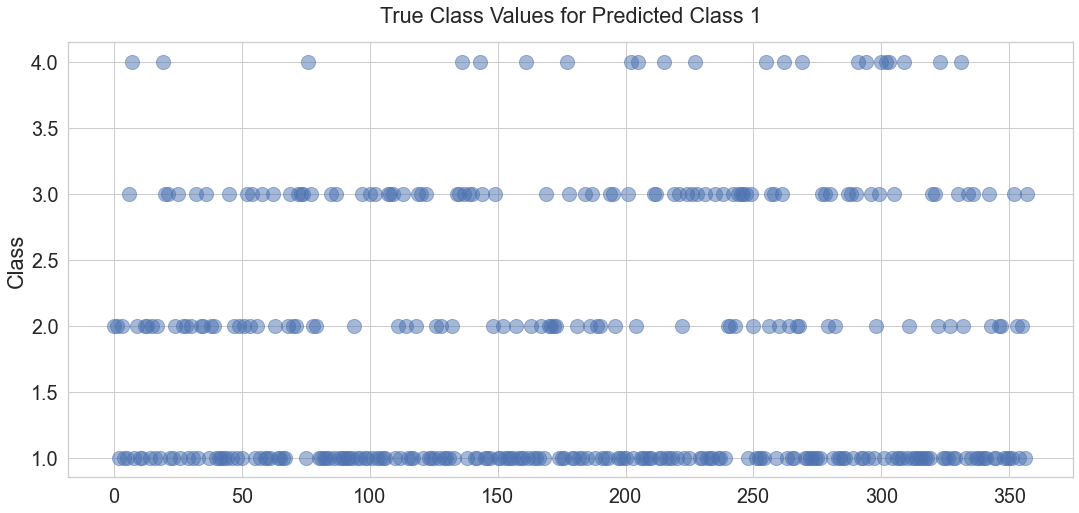

In [92]:
# plot the true class values of the predictions for Class 1

plt.figure(figsize = (18, 8))
plt.scatter(np.arange(len(y_pred_c1)), y_pred_c1, s = 200, alpha = 0.5)
plt.ylabel('Class')
plt.title('True Class Values for Predicted Class 1', pad = 20)
plt.show()

In [93]:
# create a data frame from the feature vectors corresponding to Class 1 predictions

df_pred_c1 = pd.DataFrame(X_pred_c1, columns = data.columns[0:9])
df_pred_c1.head()

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance Class
0,2,4,2,3,1,1,0,3,3
1,6,11,3,6,0,1,1,3,3
2,1,1,1,1,0,0,0,1,2
3,1,4,1,4,0,1,1,1,4
4,2,7,1,8,1,0,0,2,2


In [94]:
# add the true Position Demand class

df_pred_c1['Position Demand'] = y_pred_c1
df_pred_c1.head()

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance Class,Position Demand
0,2,4,2,3,1,1,0,3,3,2
1,6,11,3,6,0,1,1,3,3,2
2,1,1,1,1,0,0,0,1,2,1
3,1,4,1,4,0,1,1,1,4,2
4,2,7,1,8,1,0,0,2,2,1


To be able to compare to the original data we need to convert the numerical categorical values to their original counterparts.

In [96]:
# deine a function to convert back the numerical values to their original values

data_feat = 'Job Title'
dict_feat = dict_title

def get_initial_values(data, data_feat, dict_feat):
    dict_keys = list(dict_feat.keys())
    dict_vals = list(dict_feat.values())
    
    for i in range(len(data)):
        val = data[data_feat][i]
        data[data_feat][i] = dict_keys[dict_vals.index(val)]

In [101]:
# get the original values for 'Job Title' for df_pred_c1

# data_a
get_initial_values(df_pred_c1, data_feat, dict_feat)

In [102]:
# get the original values for 'Industry'

data_feat = 'Industry'
dict_feat = dict_industry

get_initial_values(df_pred_c1, data_feat, dict_feat)

In [103]:
# get the original values for 'Job Function'

data_feat = 'Job Function'
dict_feat = dict_function

get_initial_values(df_pred_c1, data_feat, dict_feat)

In [104]:
# get the original values for 'Job Function'

data_feat = 'Metro Area'
dict_feat = dict_metro

get_initial_values(df_pred_c1, data_feat, dict_feat)

In [105]:
# get the original values for 'Job Function'

data_feat = 'Seniority Level'
dict_feat = dict_seniority

get_initial_values(df_pred_c1, data_feat, dict_feat)

In [106]:
# check first few raws after getting the original values

df_pred_c1.head()

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance Class,Position Demand
0,Data Engineer,Health Care,Information Technology,SF,1,1,0,senior,3,2
1,Manager,Information Technology and Services,Other,CHI,0,1,1,senior,3,2
2,Data Scientist,Financial Services,Engineering,DC,0,0,0,entry,2,1
3,Data Scientist,Health Care,Engineering,BOS,0,1,1,entry,4,2
4,Data Engineer,Management Consulting,Engineering,ATL,1,0,0,associate,2,1


- **Determine and plot the percentages for different features in Class 1 predictions**

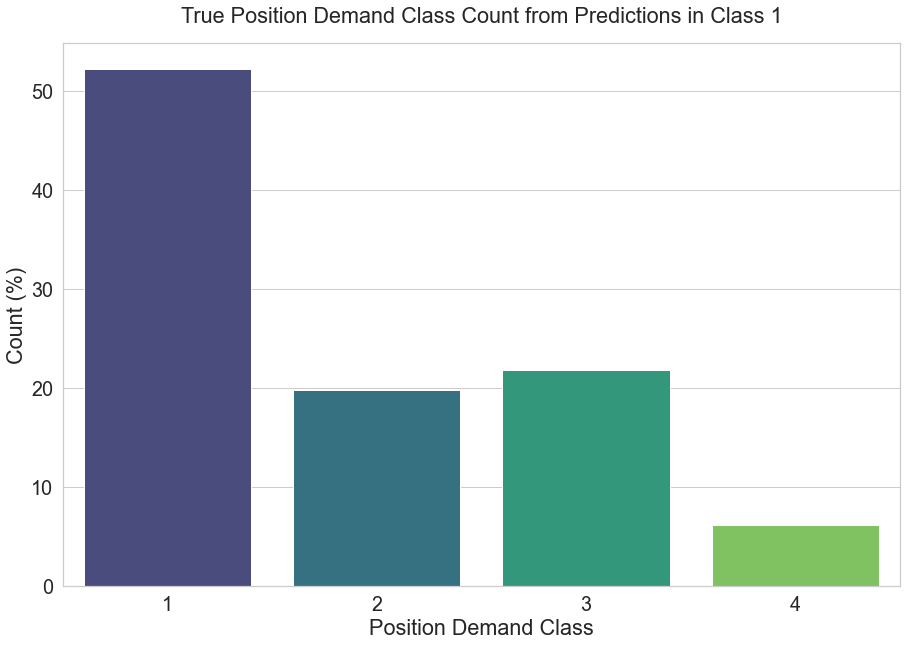

In [107]:
# first plot the true 'Position Demand' count

# get and plot the demand value count

count_demand = df_pred_c1['Position Demand'].value_counts(normalize = True) * 100

plt.figure(figsize = (15, 10))
sns.barplot(x = count_demand.index, y = count_demand.values, palette = 'viridis')
plt.xlabel('Position Demand Class')
plt.ylabel('Count (%)')
plt.title('True Position Demand Class Count from Predictions in Class 1', pad = 20)

plt.show()

This result needs to be compared to the Position Demand class counts of the data used for modeling. This will be done at the end of this section.

In [113]:
# 'Job Title' count
data_feat = 'Job Title'
count_feat = df_pred_c1[data_feat].value_counts(normalize = True) * 100
print(round(count_feat, 2))
print('\n')
print('Number of values in ' + data_feat + ': ', len(count_feat))

Data Scientist           51.68
Data Engineer            20.11
ML Engineer               6.42
Other                     6.15
Research Scientist        5.03
Manager                   3.63
ML Specialist             1.68
Analyst                   1.40
Data Architect            1.40
Applied Scientist         1.12
Consultant                0.56
Software Engineer         0.28
Scientist                 0.28
Data Science Engineer     0.28
Name: Job Title, dtype: float64


Number of values in Job Title:  14


In [114]:
# define a function to plot the count for different features

# option for different figure size
fig_size_x = 12
fig_size_y = 15

# option to plot different number of points in case the value count is to large to display all
plt_pts = len(count_feat) 

# option to adjust the x-axis range
x_min = 0
x_max = 50
d_x = 10

def count_plot(data_feat, count_feat, fig_size_x, fig_size_y, plt_pts, x_min, x_max, d_x):
    plt.figure(figsize = (fig_size_x, fig_size_y))
    sns.barplot(x = count_feat.iloc[0:plt_pts].values, y = count_feat.iloc[0:plt_pts].index, palette = 'viridis')
    plt.xlabel('Count (%)')
    plt.xlim(x_min, x_max)
    plt.xticks(np.arange(x_min, x_max + d_x , d_x))
    plt.title('Percentage of Total Number of Records in Class 1 Predictions vs. ' + data_feat, pad = 20)
    plt.show()

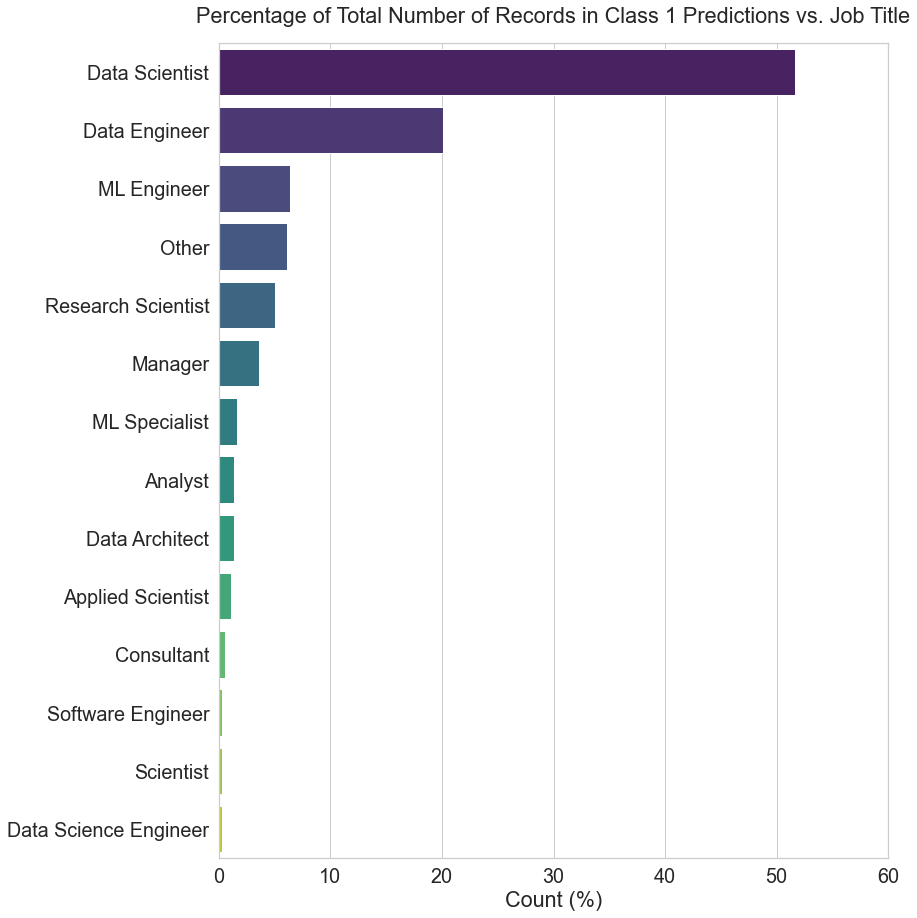

In [115]:
# 'Job Title' count
x_max = 60
d_x = 10

count_plot(data_feat, count_feat, fig_size_x, fig_size_y, plt_pts, x_min, x_max, d_x)

In [116]:
# 'Industry' count
data_feat = 'Industry'
count_feat = df_pred_c1[data_feat].value_counts(normalize = True) * 100
print(round(count_feat, 2))
print('\n')
print('Number of values in ' + data_feat + ': ', len(count_feat))

Financial Services                     21.23
Internet                               17.88
Marketing and Advertising              11.17
Health Care                             7.82
Defense                                 7.26
Computer Software                       5.31
Management Consulting                   4.75
Information Technology and Services     2.79
Biotechnology                           2.79
Network Security                        2.51
Banking                                 1.96
Telecommunications                      1.96
Manufacturing                           1.12
Real Estate                             1.12
Staffing and Recruiting                 1.12
Other                                   1.12
Consumer Goods                          1.12
Education                               0.84
Engineering                             0.84
Pharmaceutical                          0.84
Research                                0.84
Insurance                               0.56
Online Med

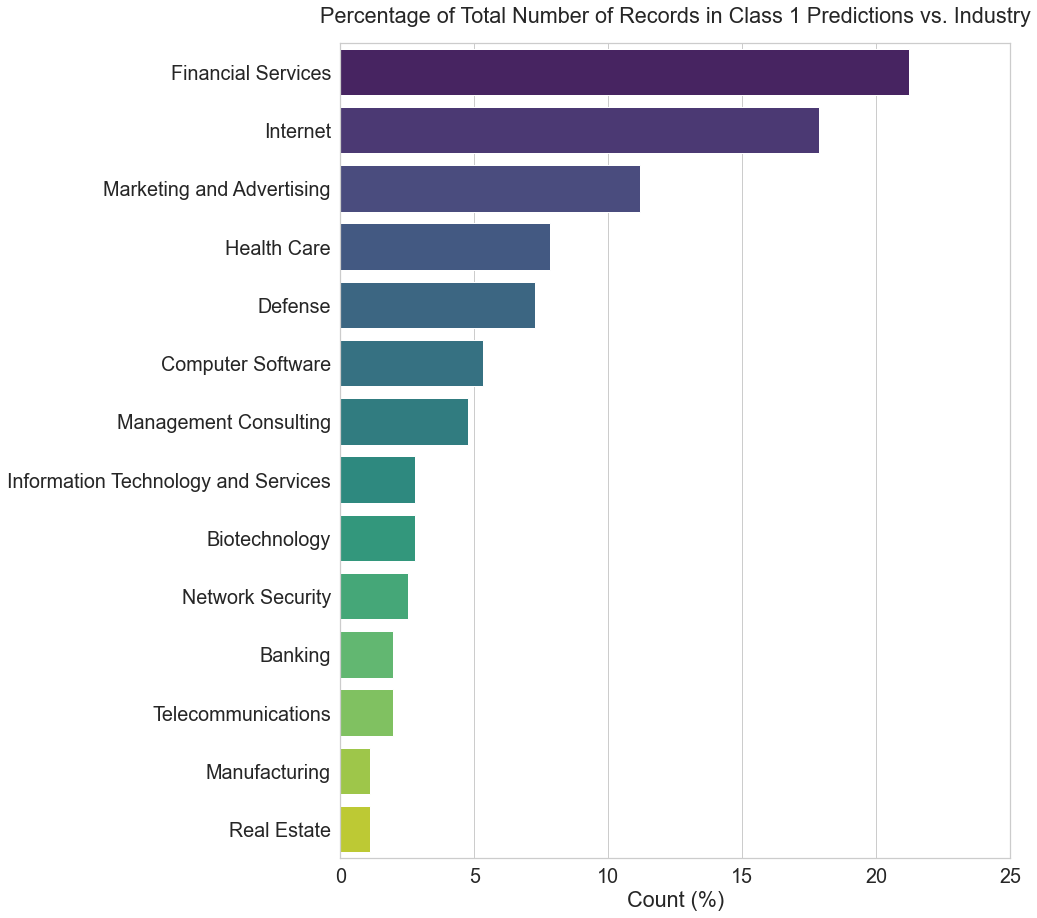

In [117]:
x_max = 25
d_x = 5

count_plot(data_feat, count_feat, fig_size_x, fig_size_y, plt_pts, x_min, x_max, d_x)

In [118]:
# 'Metro Area' count
data_feat = 'Metro Area'
count_feat = df_pred_c1[data_feat].value_counts(normalize = True) * 100
print(round(count_feat, 2))
print('\n')
print('Number of values in ' + data_feat + ': ', len(count_feat))

DC     24.30
BOS    10.34
NY      8.10
SEA     8.10
CHI     7.54
SF      6.98
ATL     6.70
LA      6.15
POR     3.91
AUS     3.35
HOU     3.07
DAL     3.07
PHX     2.79
PHI     2.51
SD      1.96
NC      1.12
Name: Metro Area, dtype: float64


Number of values in Metro Area:  16


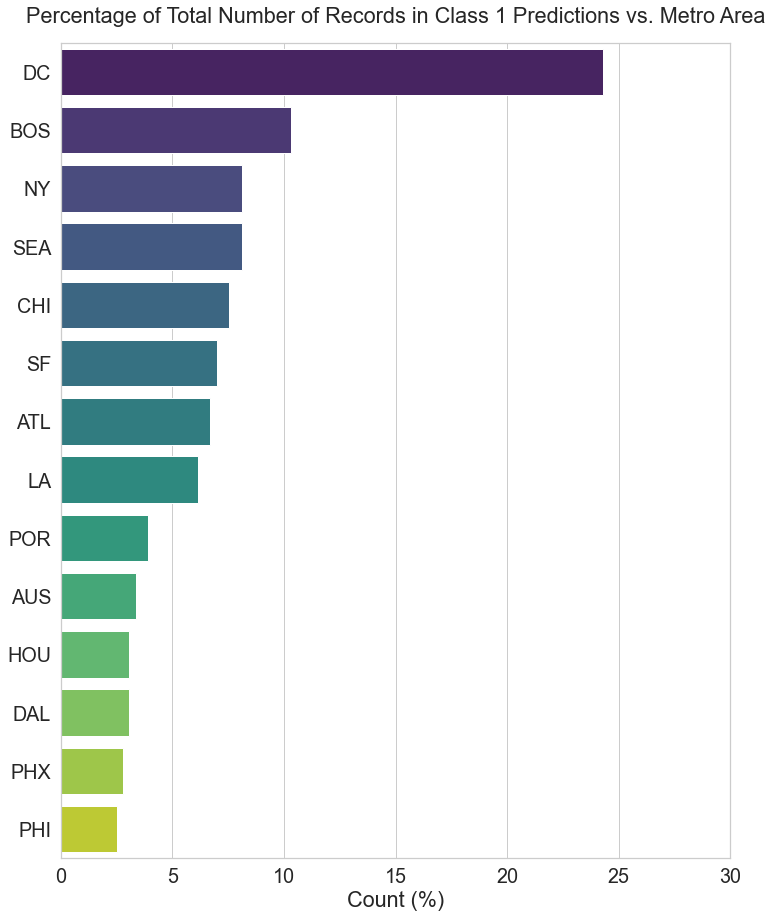

In [119]:
x_max = 30
d_x = 5

count_plot(data_feat, count_feat, fig_size_x, fig_size_y, plt_pts, x_min, x_max, d_x)

In [120]:
# 'Seniority Level' count
data_feat = 'Seniority Level'
count_feat = df_pred_c1[data_feat].value_counts(normalize = True) * 100
print(round(count_feat, 2))
print('\n')
print('Number of values in ' + data_feat + ': ', len(count_feat))

associate    38.55
senior       30.73
entry        30.73
Name: Seniority Level, dtype: float64


Number of values in Seniority Level:  3


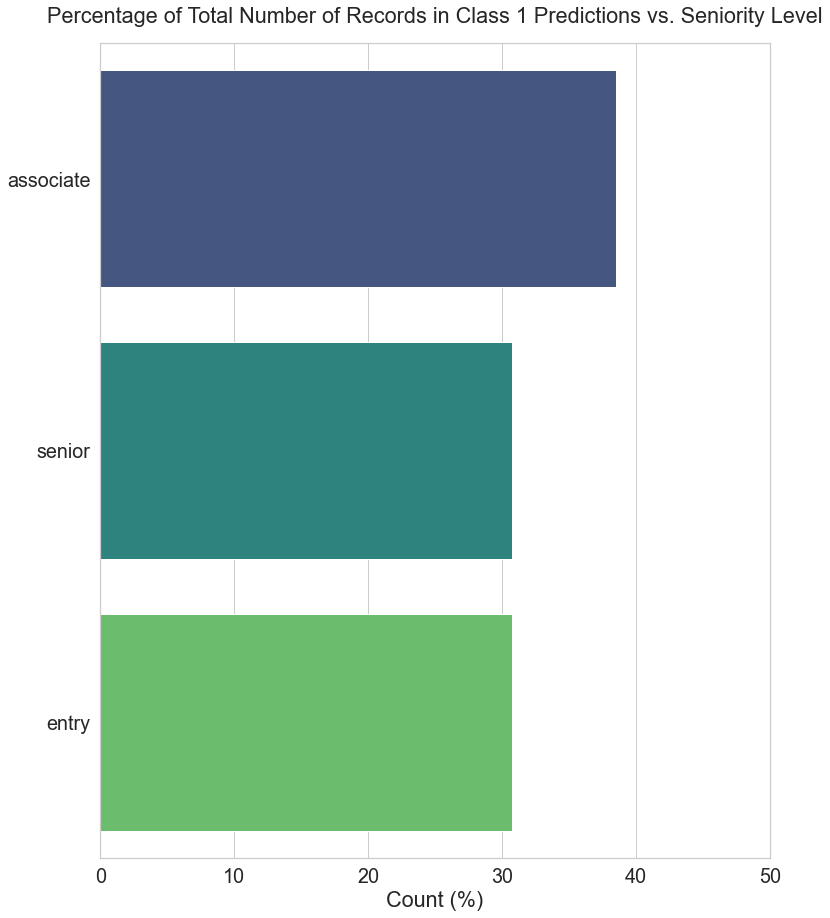

In [121]:
x_max = 50
d_x = 10

count_plot(data_feat, count_feat, fig_size_x, fig_size_y, plt_pts, x_min, x_max, d_x)

### Comparison with data used in model

It is time to compare the above results obtained from the predictions for Class 1 to the corresponding results from the data set which was used for this model.

In [122]:
# load data again

data = pd.read_excel('data/jobs_ds_s1_s5_model.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Job Title           4846 non-null   object
 1   Industry            4846 non-null   object
 2   Job Function        4846 non-null   object
 3   Metro Area          4846 non-null   object
 4   Education-Bachelor  4846 non-null   int64 
 5   Education-Master    4846 non-null   int64 
 6   Education-Doctor    4846 non-null   int64 
 7   Seniority Level     4846 non-null   object
 8   Relevance Class     4846 non-null   int64 
 9   Position Demand     4846 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 378.7+ KB


In [124]:
data.head()

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance Class,Position Demand
0,Data Scientist,Staffing and Recruiting,Engineering,ATL,0,1,1,entry,3,3
1,Data Scientist,Staffing and Recruiting,Information Technology,ATL,1,1,0,entry,1,3
2,Data Scientist,Financial Services,Engineering,ATL,0,0,0,entry,2,3
3,Data Scientist,Financial Services,Engineering,ATL,0,1,0,entry,2,4
4,Data Scientist,Research,Analyst,ATL,0,0,0,entry,2,3


Recall that the data used for modeling was derived from the original data by removing the job titles below 0.1%.

In [126]:
# 'Job Title' count
data_feat = 'Job Title'
count_feat = data[data_feat].value_counts(normalize = True) * 100
print(round(count_feat, 2))
print('\n')
print('Number of values in ' + data_feat + ': ', len(count_feat))

Data Scientist             54.56
Data Engineer              17.29
ML Engineer                10.05
Other                       6.05
Research Scientist          3.01
Manager                     2.33
Analyst                     1.67
Consultant                  1.13
Software Engineer           0.76
ML Specialist               0.74
Data Architect              0.72
Applied Scientist           0.54
Data Science Engineer       0.45
Scientist                   0.21
Quantitative Researcher     0.17
Director                    0.08
UX Researcher               0.08
Postdoctoral Researcher     0.06
Market Researcher           0.04
Researcher                  0.04
Name: Job Title, dtype: float64


Number of values in Job Title:  20


In [127]:
# create filter for titles above 0.1% and select only that portion of the data as a new dataset, data_s

titles_select = count_feat[count_feat.values > 0.1].index
mask_titles_select = data[data_feat].isin(titles_select)

data_s = data[mask_titles_select]
data_s.reset_index(inplace = True, drop = True)
data_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4831 entries, 0 to 4830
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Job Title           4831 non-null   object
 1   Industry            4831 non-null   object
 2   Job Function        4831 non-null   object
 3   Metro Area          4831 non-null   object
 4   Education-Bachelor  4831 non-null   int64 
 5   Education-Master    4831 non-null   int64 
 6   Education-Doctor    4831 non-null   int64 
 7   Seniority Level     4831 non-null   object
 8   Relevance Class     4831 non-null   int64 
 9   Position Demand     4831 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 377.5+ KB


It appears that only 15 records were removed from the original data and yet this resulted in measurable improvements in the model predictions.

In [128]:
data_s.head()

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance Class,Position Demand
0,Data Scientist,Staffing and Recruiting,Engineering,ATL,0,1,1,entry,3,3
1,Data Scientist,Staffing and Recruiting,Information Technology,ATL,1,1,0,entry,1,3
2,Data Scientist,Financial Services,Engineering,ATL,0,0,0,entry,2,3
3,Data Scientist,Financial Services,Engineering,ATL,0,1,0,entry,2,4
4,Data Scientist,Research,Analyst,ATL,0,0,0,entry,2,3


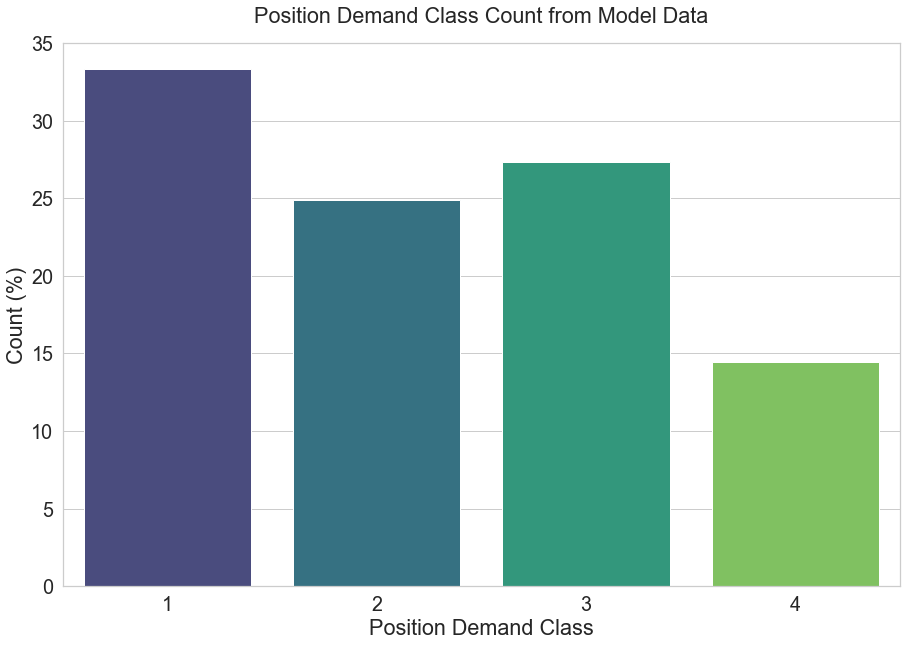

In [129]:
# get and plot the demand value count

count_demand = data_s['Position Demand'].value_counts(normalize = True) * 100

plt.figure(figsize = (15, 10))
sns.barplot(x = count_demand.index, y = count_demand.values, palette = 'viridis')
plt.xlabel('Position Demand Class')
plt.ylabel('Count (%)')
plt.title('Position Demand Class Count from Model Data', pad = 20)

plt.show()

Compare this result with the corresponding result from Class 1 predictions.

For the rest of the plots we need to select only the data which belongs to the true Class 1.

In [133]:
data_c1 = data_s[data_s['Position Demand'] == 1]

data_feat = 'Job Title'
count_feat = data_c1[data_feat].value_counts(normalize = True) * 100
print(round(count_feat, 2))
print('\n')
print('Number of values in ' + data_feat + ': ', len(count_feat))

Data Scientist           51.09
Data Engineer            19.06
ML Engineer               7.51
Other                     7.32
Manager                   3.85
Research Scientist        3.41
Analyst                   2.05
Software Engineer         1.18
Consultant                1.18
Data Architect            1.12
ML Specialist             0.87
Applied Scientist         0.74
Data Science Engineer     0.37
Scientist                 0.25
Name: Job Title, dtype: float64


Number of values in Job Title:  14


In [134]:
# define a function to plot the count for different features from model data

fig_size_x = 12
fig_size_y = 15

# option to plot different number of points in case the value count is to large to display all
plt_pts = len(count_feat) 

# option to adjust the x-axis range
x_min = 0
x_max = 50
d_x = 10

def count_plot(data_feat, count_feat, fig_size_x, fig_size_y, plt_pts, x_min, x_max, d_x):
    plt.figure(figsize = (fig_size_x, fig_size_y))
    sns.barplot(x = count_feat.iloc[0:plt_pts].values, y = count_feat.iloc[0:plt_pts].index, palette = 'viridis')
    plt.xlabel('Count (%)')
    plt.xlim(x_min, x_max)
    plt.xticks(np.arange(x_min, x_max + d_x , d_x))
    plt.title('Percentage of Class 1 Records in Model Data vs. ' + data_feat, pad = 20)
    plt.show()

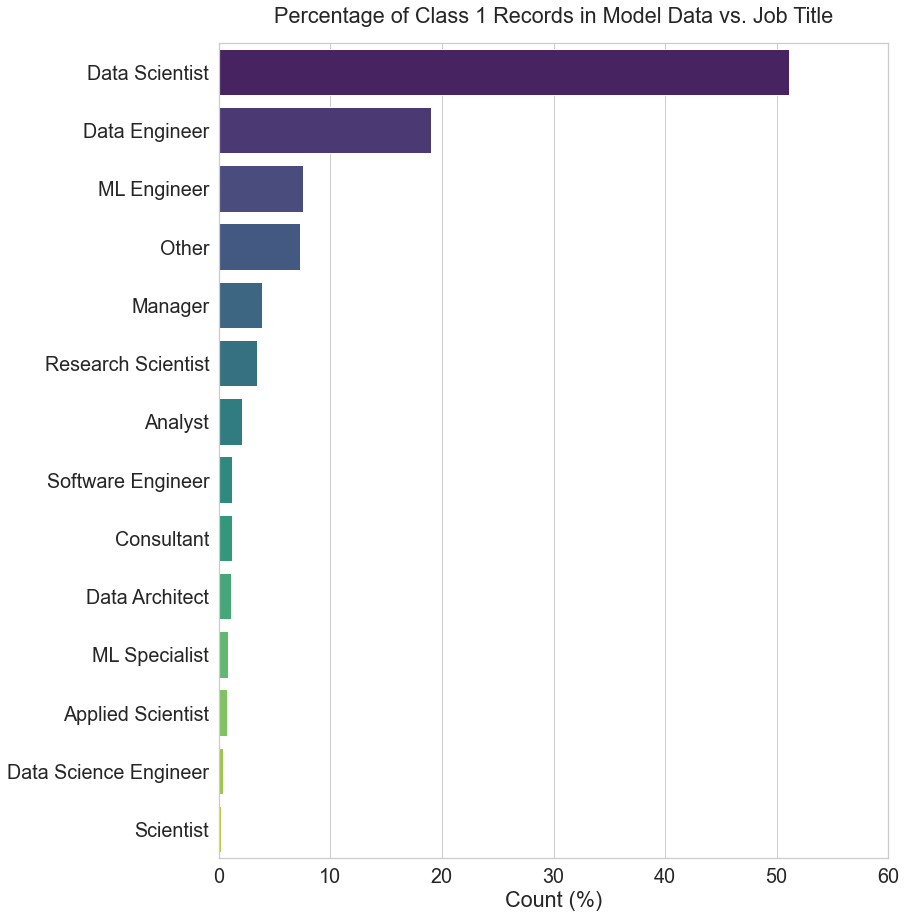

In [135]:
# 'Job Title' count
x_max = 60
d_x = 10

count_plot(data_feat, count_feat, fig_size_x, fig_size_y, plt_pts, x_min, x_max, d_x)

In [136]:
# 'Industry' count
data_feat = 'Industry'
count_feat = data_c1[data_feat].value_counts(normalize = True) * 100
print(round(count_feat, 2))
print('\n')
print('Number of values in ' + data_feat + ': ', len(count_feat))

Financial Services                     18.68
Internet                               17.19
Marketing and Advertising              11.86
Health Care                             7.76
Defense                                 6.21
Management Consulting                   5.46
Computer Software                       4.78
Banking                                 2.92
Staffing and Recruiting                 2.67
Biotechnology                           2.36
Information Technology and Services     2.05
Insurance                               1.99
Network Security                        1.86
Education                               1.74
Telecommunications                      1.68
Manufacturing                           1.61
Construction                            0.93
Research                                0.93
Other                                   0.87
Automotive                              0.68
Real Estate                             0.62
Online Media                            0.62
Medical De

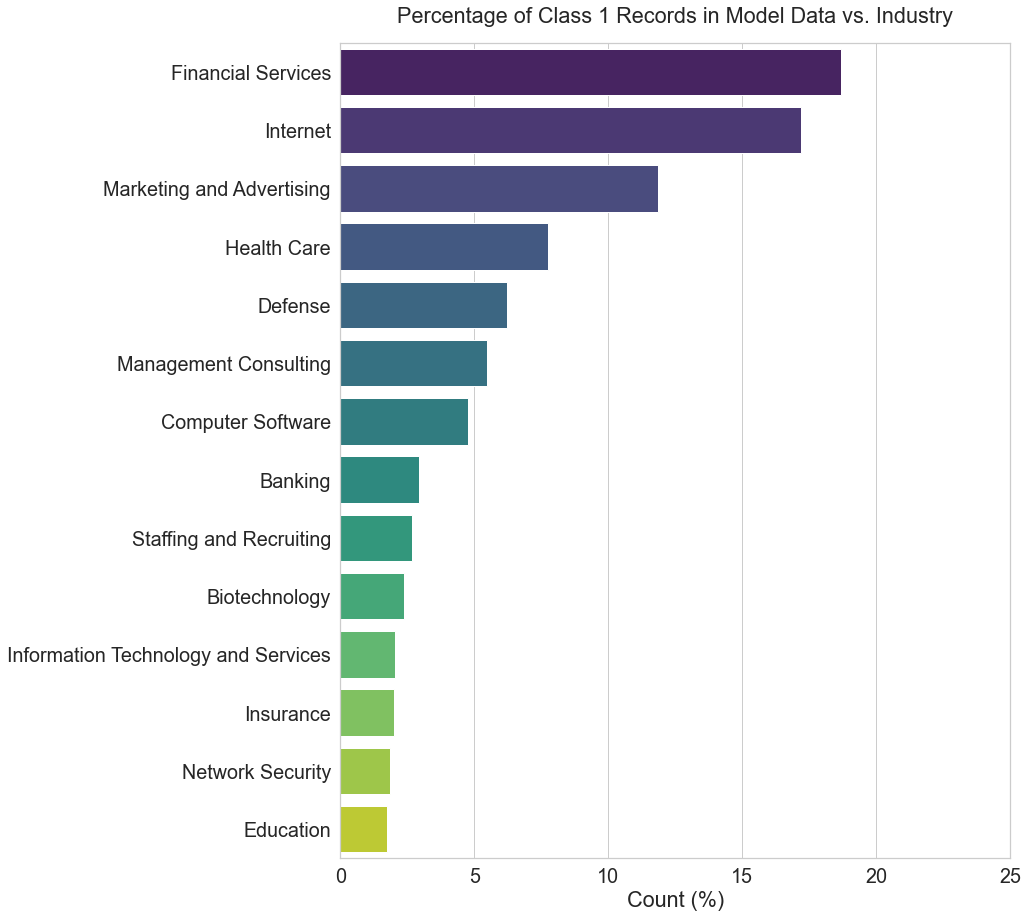

In [137]:
x_max = 25
d_x = 5

count_plot(data_feat, count_feat, fig_size_x, fig_size_y, plt_pts, x_min, x_max, d_x)

In [138]:
# 'Metro Area' count
data_feat = 'Metro Area'
count_feat = data_c1[data_feat].value_counts(normalize = True) * 100
print(round(count_feat, 2))
print('\n')
print('Number of values in ' + data_feat + ': ', len(count_feat))

DC     21.29
NY     10.12
BOS     9.56
SF      8.69
SEA     8.32
CHI     7.08
ATL     6.64
LA      4.84
DAL     4.47
PHI     3.48
AUS     3.41
PHX     3.10
HOU     2.67
POR     2.48
SD      2.23
NC      1.61
Name: Metro Area, dtype: float64


Number of values in Metro Area:  16


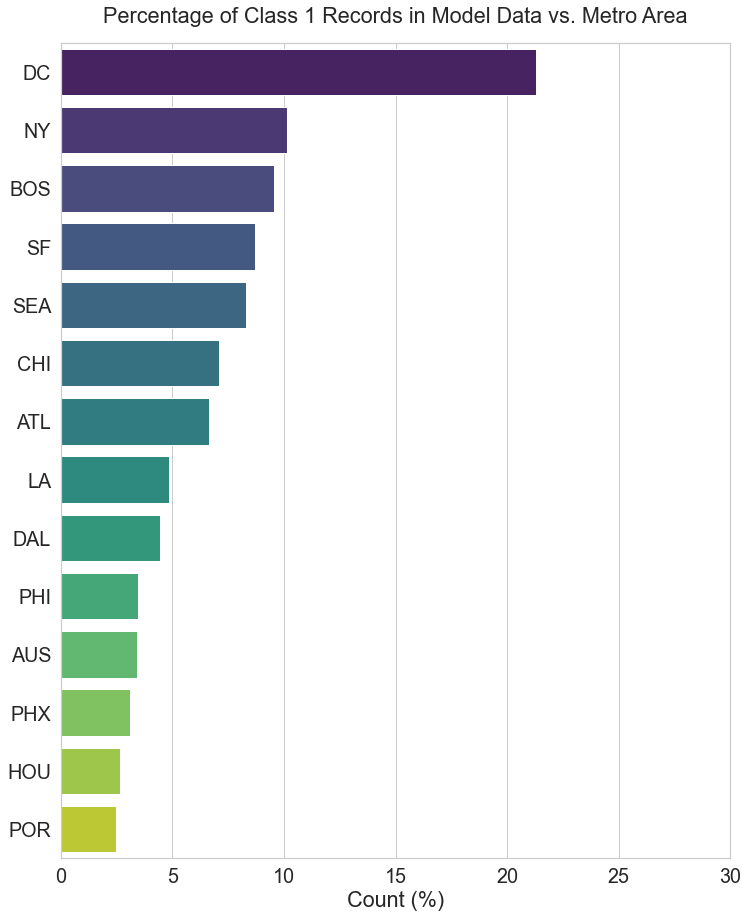

In [139]:
x_max = 30
d_x = 5

count_plot(data_feat, count_feat, fig_size_x, fig_size_y, plt_pts, x_min, x_max, d_x)

In [140]:
# 'Seniority Level' count
data_feat = 'Seniority Level'
count_feat = data_c1[data_feat].value_counts(normalize = True) * 100
print(round(count_feat, 2))
print('\n')
print('Number of values in ' + data_feat + ': ', len(count_feat))

associate    36.19
senior       32.59
entry        31.22
Name: Seniority Level, dtype: float64


Number of values in Seniority Level:  3


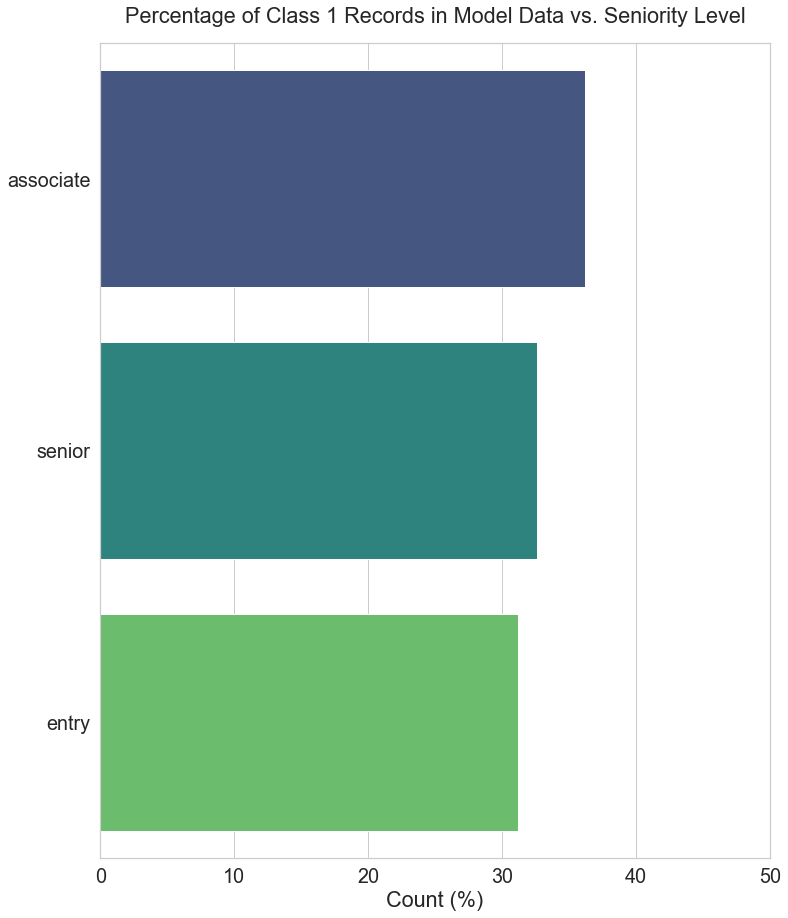

In [141]:
x_max = 50
d_x = 10

count_plot(data_feat, count_feat, fig_size_x, fig_size_y, plt_pts, x_min, x_max, d_x)